# Music Genre Identification
## Portland Data Science Group, 2019/08/04

Paper: https://arxiv.org/pdf/1612.01840.pdf \
git: https://github.com/mdeff/fma \
Data: http://dive-into.info/2039/warmup_small.zip \
Feature usage: https://nbviewer.jupyter.org/github/mdeff/fma/blob/outputs/usage.ipynb

A python package for music and audio analysis - [librosa](https://github.com/librosa/librosa)

In [1]:
import matplotlib.colors as cols
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import os
import random
import itertools

from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn import decomposition

from sklearn.naive_bayes import BernoulliNB 
from sklearn.metrics import roc_curve, auc, classification_report, f1_score, confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

import IPython.display as ipd

import seaborn as sns

# Librosa for audio
import librosa
# And the display module for visualization
import librosa.display

from IPython.display import display
#save graphics as pdf too (for less revolting exported plots)
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

# Data Load and Exploration
The initial dataset contains 100 Hip-hop and 100 Folk songs. The dataset also contains metadata for each track, which we can use to assosiate genres.

### Ideas for analysis
1. Fourier transform of songs to find dominant frequencies
2. Transcribing songs and separating the lyrics (or recognizing difference between singing and spoken words)
3. Identifying tempos and keys in each song
4. Identifying loud volume / strong beats
5. Recognizing instruments
6. Difference in volume - long quiet periods in folk vs loud hip-hop

We will try to find features from the audio samples by decomposing the track using short-time fast fourier transform (SFFT) to find dominant frequencies and rythems to separate the two genres.

In [2]:
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

df = pd.read_csv("data/warmup/pdsg_musicgenre_warmup_small.csv")

In [3]:
df.head()

Unnamed: 0  track_id  comments         date_created        date_released      engineer  favorites       id                                        information  listens      producer tags                                              title  tracks           type    active_year_begin active_year_end associated_labels                                                bio  comments.1       date_created.1  favorites.1     id.1   latitude            location  longitude members              name related_projects                                  tags.1                                            website                                     wikipedia_page     split subset  bit_rate  comments.2 composer       date_created.2        date_recorded  duration  favorites.2 genre_top     genres genres_all                                      information.1  interest language_code                                            license  listens.1 lyricist  number  publisher tags.2  \
0       91048    133803       0.0  2016-03-06 14:58:50  2015-08-31 00:00:00           NaN        0.0  20099.0                                                NaN  13021.0           NaN   []                                     The Other Side    16.0          Album                  NaN             NaN               NaN  <p>David Rovics grew up in a family of classic...         0.0  2011-07-05 09:48:06          4.0  11346.0        NaN  Portland, OR 97201        NaN     NaN      David Rovics              NaN                        ['david rovics']                                    davidrovics.com                                                NaN  training  small  128000.0         0.0      NaN  2016-03-06 15:05:51                  NaN     129.0          0.0      Folk  [17, 103]  [17, 103]                                                NaN    1936.0           NaN  Creative Commons Attribution-NonCommercial-NoD...     1813.0      NaN    16.0        NaN     []   
1       88664    130944       0.0  2016-01-16 12:08:49  2015-10-16 00:00:00           NaN        1.0  19720.0  <p>L’ancien duo voix-guitares <a href="http://...   3694.0           NaN   []                                    La Cantine Boga     8.0          Album                  NaN             NaN               NaN  <p>L’ancien duo voix-guitares <a href="http://...         0.0  2016-01-16 12:17:41          3.0  21538.0        NaN      Madrid (Spain)        NaN     NaN   La Cantine Boga              NaN                     ['la cantine boga']                  http://lacantineboga.bandcamp.com                                                NaN  training  small  232386.0         0.0      NaN  2016-01-16 12:16:52                  NaN     243.0          3.0      Folk       [17]       [17]                                                NaN     816.0           NaN  Creative Commons Attribution-NonCommercial-NoD...      688.0      NaN     8.0        NaN     []   
2        2334      4069       0.0  2008-12-04 09:27:35  2008-06-09 00:00:00  Irene Trudel        0.0    897.0  <p>A true original on the 60's Greenwich Villa...   3052.0  Irene Trudel   []    Live at WFMU on Irene Trudel's Show on 6/9/2008     4.0  Radio Program                  NaN             NaN               NaN  <p>Walker was born in Boston, MA in 1937, into...         0.0  2008-12-04 09:23:21          1.0   1374.0        NaN                 NaN        NaN     NaN      Peter Walker              NaN  ['fingerstyle guitar', 'peter walker']  http://www.myspace.com/httpwwwmyspacecompeterw...  http://en.wikipedia.org/wiki/Peter_Walker_(gui...  training  small  256000.0         0.0      NaN  2008-12-04 20:46:26  2008-06-09 00:00:00     233.0          6.0      Folk       [33]   [33, 17]                                                NaN    4883.0            en  Attribution-Noncommercial-Share Alike 3.0 Unit...     1693.0      NaN     4.0        NaN     []   
3       72808    110439       0.0  2014-10-30 18:07:49  2014-10-30 00:00:00  Matt Marando        1.0  17108.0  <p> </p>

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 55 columns):
Unnamed: 0           200 non-null int64
track_id             200 non-null int64
comments             200 non-null float64
date_created         200 non-null object
date_released        141 non-null object
engineer             43 non-null object
favorites            200 non-null float64
id                   200 non-null float64
information          156 non-null object
listens              200 non-null float64
producer             50 non-null object
tags                 200 non-null object
title                200 non-null object
tracks               200 non-null float64
type                 189 non-null object
active_year_begin    38 non-null object
active_year_end      11 non-null object
associated_labels    12 non-null object
bio                  164 non-null object
comments.1           200 non-null float64
date_created.1       200 non-null object
favorites.1          200 non-null f

In [5]:
cols_genres = ['genre_top', 'genres', 'genres_all']
print("Unique Genres: ", df['genre_top'].unique())

Unique Genres:  ['Folk' 'Hip-Hop']


In [6]:
# Adding filenames to dataset
audio_path = 'data/warmup'
filenames = []
for i, song_id in enumerate(df['track_id']):
    filename = '%s/%06d.wav' % (audio_path, song_id)
    df.loc[i, 'filename'] = filename
        
df_folk = df[df['genre_top']=='Folk']
df_hiphop = df[df['genre_top']=='Hip-Hop']

### Listening to audio samples

In [7]:
folk_sample =  df_folk.iloc[0]
print("Folk Sample: ", folk_sample['filename'])
ipd.Audio(folk_sample['filename'])

Folk Sample:  data/warmup/133803.wav


In [8]:
hiphop_sample = df_hiphop.iloc[1]
print("Hiphop Sample: ", hiphop_sample['filename'])
ipd.Audio(hiphop_sample['filename'])

Hiphop Sample:  data/warmup/130650.wav


There are clear differences between these two tracks, with the Folk track being a lot more instrumental, which means higher frequencies will be more pronounced, and the Hiphop track being mostly vocal/speech, so lower frequencies will be dominant. Let's look at the spectograms of each.

### Function Definitions

In [9]:
"""
Mel Spectrogram
"""
def mel_spec(filename, title='', y_axis='mel'):
    y, sr = librosa.load(filename)
    S = librosa.feature.melspectrogram(y, sr)
    log_S = librosa.power_to_db(S, ref=np.max)

    plt.figure(figsize=(12, 4))
    librosa.display.specshow(log_S, sr=sr, x_axis='time', y_axis=y_axis)
    plt.title(f'mel power spectrogram: {title}')
    plt.colorbar(format='%+02.0f dB')
    plt.tight_layout()


"""
Harmonic / Percussive separation
"""
def harmonic_percussive_separation(filename):
    y, sr = librosa.load(filename)
    y_harmonic, y_percussive = librosa.effects.hpss(y)
    S_harmonic   = librosa.feature.melspectrogram(y_harmonic, sr=sr)
    S_percussive = librosa.feature.melspectrogram(y_percussive, sr=sr)
    log_S_harmonic = librosa.power_to_db(S_harmonic, ref=np.max)
    log_S_percussive = librosa.power_to_db(S_percussive, ref=np.max)
    return log_S_harmonic, log_S_percussive, sr


def mel_spec_harmonic_percussive(filename, title='', y_axis='mel'):
    plt.figure(figsize=(12, 8))
    log_S_harmonic, log_S_percussive, sr = harmonic_percussive_separation(filename)
    plt.subplot(2, 1, 1)
    librosa.display.specshow(log_S_harmonic, sr=sr, x_axis='time', y_axis=y_axis)
    plt.title(f'mel power spectrogram Harmonic: {title}')
    plt.colorbar(format='%+02.0f dB')
    plt.subplot(2, 1, 2)
    librosa.display.specshow(log_S_percussive, sr=sr, x_axis='time', y_axis=y_axis)
    plt.title(f'mel power spectrogram Percussive: {title}')
    plt.colorbar(format='%+02.0f dB')
    plt.tight_layout()

    
def chromogram(filename, title=''):
    y, sr = librosa.load(filename)
    y_harmonic, y_percussive = librosa.effects.hpss(y)
    C = librosa.feature.chroma_cqt(y=y_harmonic, sr=sr, bins_per_octave=36)

    plt.figure(figsize=(12,4))
    librosa.display.specshow(C, sr=sr, x_axis='time', y_axis='chroma', vmin=0, vmax=1)
    plt.title(f'Chromagram: {title}')
    plt.colorbar()
    plt.tight_layout()
    
    
def mfcc_plot(filename, title=''):
    #log_S_harmonic, log_S_percussive, sr = harmonic_percussive_separation(filename)
    #mfcc        = librosa.feature.mfcc(S=log_S_percussive, n_mfcc=13)

    y, sr = librosa.load(filename)
    S = librosa.feature.melspectrogram(y, sr)
    mfcc        = librosa.feature.mfcc(S=S, n_mfcc=13)

    delta_mfcc  = librosa.feature.delta(mfcc)
    delta2_mfcc = librosa.feature.delta(mfcc, order=2)

    plt.figure(figsize=(12, 6))

    plt.subplot(3,1,1)
    librosa.display.specshow(mfcc)
    plt.title(f'MFCC: {title}')
    plt.ylabel('MFCC')
    plt.colorbar()

    plt.subplot(3,1,2)
    librosa.display.specshow(delta_mfcc)
    plt.title(f'MFCC-$\Delta$: {title}')
    plt.ylabel('MFCC-$\Delta$')
    plt.colorbar()

    plt.subplot(3,1,3)
    librosa.display.specshow(delta2_mfcc, sr=sr, x_axis='time')
    
    plt.title(f'MFCC-$\Delta^2$: {title}')
    plt.ylabel('MFCC-$\Delta^2$')
    plt.colorbar()

    plt.tight_layout()

    M = np.vstack([mfcc, delta_mfcc, delta2_mfcc])
    return M


def mfcc_features(filename, n_mfcc=20, separation='all'):
    y, sr = librosa.load(filename)
    if separation == 'precussive':
        y_harmonic, y_percussive = librosa.effects.hpss(y)
        y = y_percussive
    elif separation == 'harmonic':
        y_harmonic, y_percussive = librosa.effects.hpss(y)
        y = y_harmonic
    S = librosa.feature.melspectrogram(y, sr)
    mfcc = librosa.feature.mfcc(S=S, n_mfcc=n_mfcc)
    mfcc_stats = {
        'kurtosis': stats.kurtosis(mfcc, axis=1),
        'mean': np.mean(mfcc, axis=1),
        'min': np.min(mfcc, axis=1),
        'max': np.max(mfcc, axis=1),
        'median': np.median(mfcc,axis=1),
        'std': np.std(mfcc, axis=1),
        'skew': stats.skew(mfcc, axis=1),
    }
    return np.concatenate([
        mfcc_stats['kurtosis'],
        mfcc_stats['mean'],
        mfcc_stats['min'],
        mfcc_stats['max'],
        mfcc_stats['median'],
        mfcc_stats['std'],
        mfcc_stats['skew']
    ])

## Mel Spectrogram
A first glance at the audio sample is to look at short-time fourier transform (SFFT) of the signal in the form of a spectrogram. This allows us to see the prevalence of low and high frequencies in both the *Hiphop* and *Folk* audio samples. For instance, the long bands in the higher frequencies in the Folk sample are the higher harmonics of the violin.

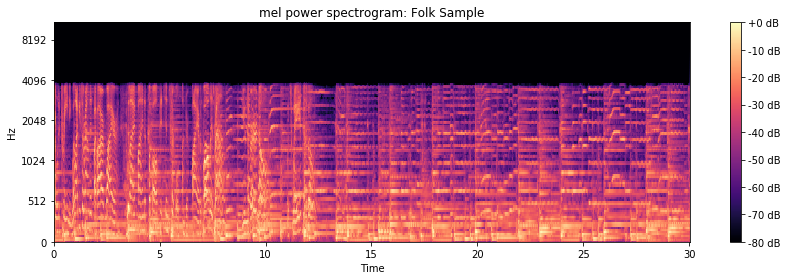

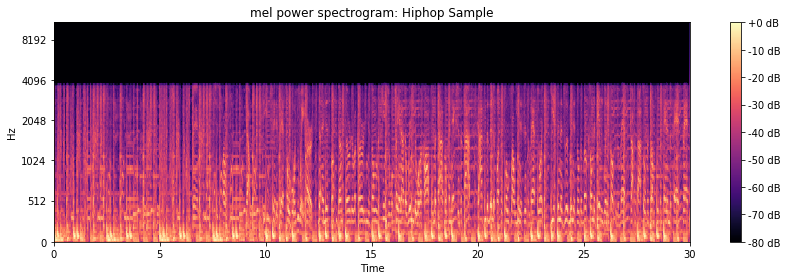

In [10]:
#y_axis_scale='log'
y_axis_scale='mel'
mel_spec(folk_sample['filename'], 'Folk Sample', y_axis_scale)
mel_spec(hiphop_sample['filename'], 'Hiphop Sample', y_axis_scale)

### Harmonic and Percussive separation
We will try to separate the harmonic and percussive comonents of the track and look at their frequencies. The percussive component represents a key being hit or a chord being strung, while the harmonic component represents when that note lingers (e.g. a violin or piano keeping a note).

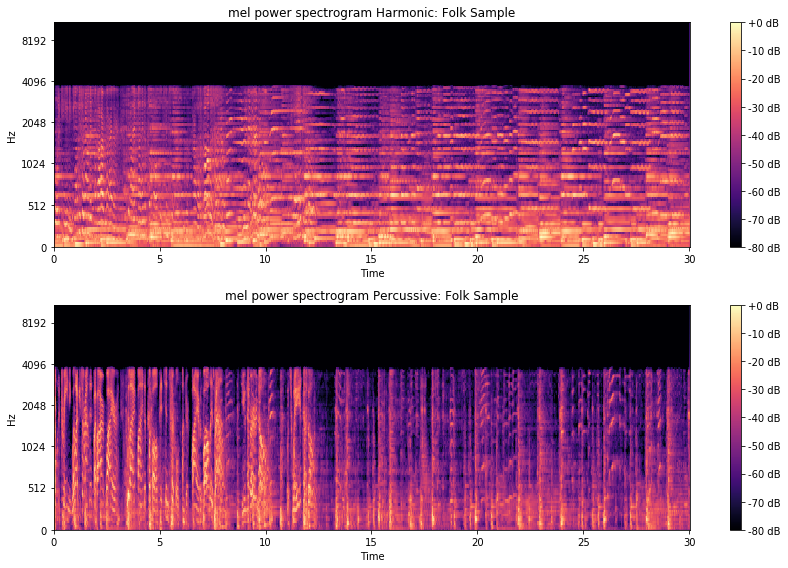

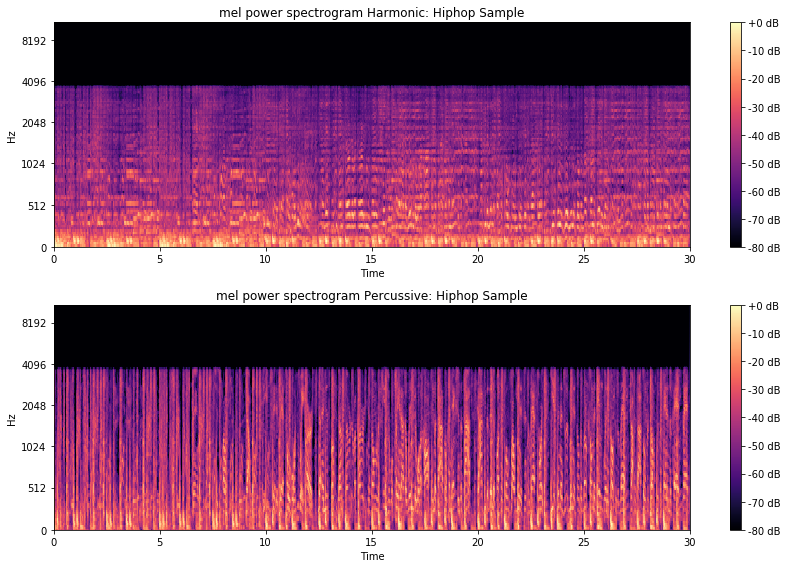

In [11]:
mel_spec_harmonic_percussive(folk_sample['filename'], 'Folk Sample', y_axis_scale)
mel_spec_harmonic_percussive(hiphop_sample['filename'], 'Hiphop Sample', y_axis_scale)

The difference between these tracks in both percussive and harmonic components are pretty striking. The percussive component of the Hiphop track shows a much higher repetition than that of the Folk track, possibly representing a fast drum beat. The harmonic component of the Folk track shows long lingering notes of instruments played, while the Hiphop track has very short harmonics, mainly dominated by lower frequencies.

## Chromogram
The chromogram represents the pitch progression of each track. Since most music uses a variety of notes, we don't expect to see a major difference in pitches, but rather in perhaps the diffence progression in each track. 

/Users/niramram/.venv/3/lib/python3.7/site-packages/scipy/sparse/lil.py:504: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not i.flags.writeable or i.dtype not in (np.int32, np.int64):
/Users/niramram/.venv/3/lib/python3.7/site-packages/scipy/sparse/lil.py:506: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not j.flags.writeable or j.dtype not in (np.int32, np.int64):


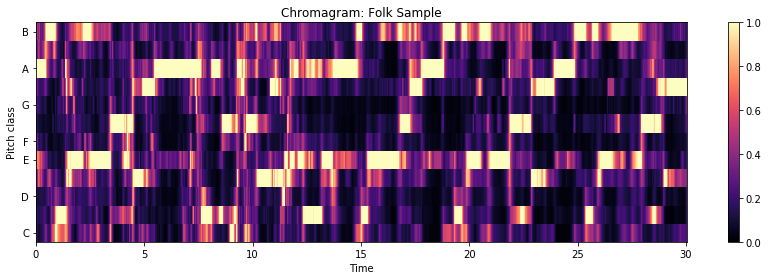

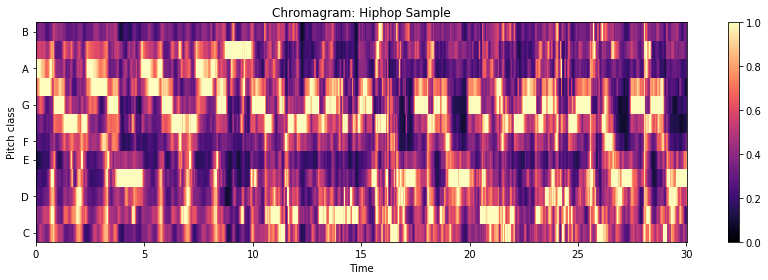

In [12]:
chromogram(folk_sample['filename'], 'Folk Sample')
chromogram(hiphop_sample['filename'], 'Hiphop Sample')

Indeed the hiphop track seems to have much faster and varied pitch progression. The pitches also seem "washed out" and not as precise and lingering as the Folk track. This is probably due to the singer's fast speech which doesn't hold a constant note and rather smears the frequencies.

## Mel-Frequency Cepstral Coefficients (MFCC)

#### Folk Sample

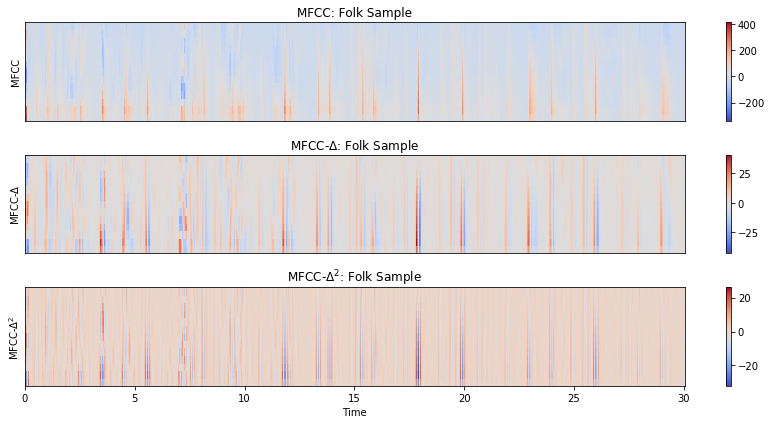

In [13]:
M_folk = mfcc_plot(folk_sample['filename'], 'Folk Sample')

#### Hip-hop sample

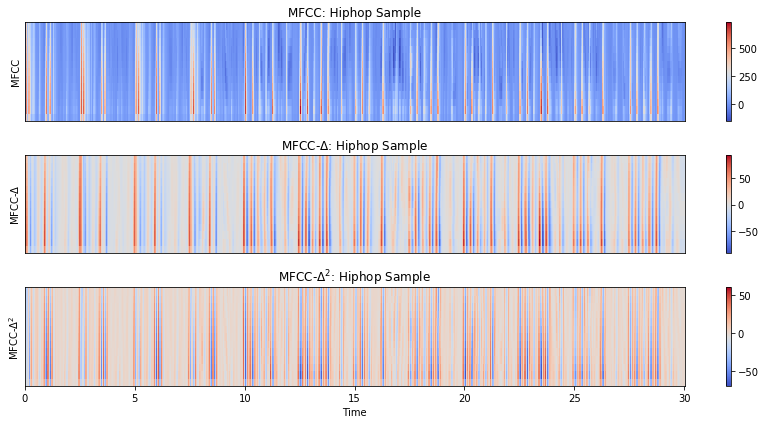

In [14]:
M_hiphop = mfcc_plot(hiphop_sample['filename'], 'Hiphop Sample')

In [15]:
n_mfcc = 20
mfcc_folk = mfcc_features(folk_sample['filename'], n_mfcc, 'all')
mfcc_hiphop = mfcc_features(hiphop_sample['filename'], n_mfcc, 'all')

# Small-scale predictions using MFCC
We will use the MFCC features to build a simple prediction model for a small sample of events. 

After extracting the MFCC features from all the samples, the results are saved into an additional dataset for faster reference.

In [16]:
columns = pd.MultiIndex.from_product(
    [['kurtosis', 'mean', 'min', 'max', 'median', 'std', 'skew'], np.arange(1,21)],
    names=['stats', 'channel'])
n_mfcc = 20
mfcc_separation = 'all'
df_mfcc = pd.DataFrame([mfcc_features(filename, n_mfcc, mfcc_separation) 
                        for filename in df.filename], index=df.track_id, columns=columns)
df_mfcc['genre'] = df.set_index('track_id')['genre_top']

## PCA Decomposition
To illustrate the separation of the two sample sets, we will attempt a simple PCA decomposition

Text(0.5, 1.0, 'Folk/Hiphop MFCC PCA decomposition')

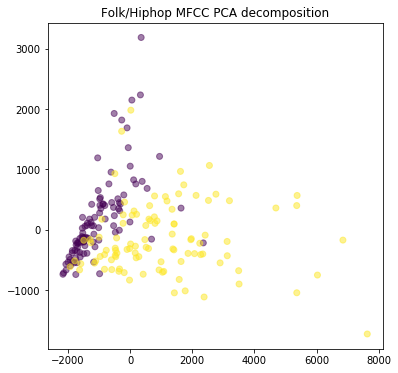

In [17]:
cols_features = ['kurtosis', 'mean', 'min', 'max', 'median', 'std', 'skew']
X = df_mfcc.loc[:, cols_features]
X = decomposition.PCA(n_components=2).fit_transform(X)
y = df_mfcc['genre']
y = LabelEncoder().fit_transform(y)

plt.figure(figsize=(6, 6))
plt.scatter(X[:,0], X[:,1], c=y, alpha=0.5)
plt.title('Folk/Hiphop MFCC PCA decomposition')

While the decomposition does a decent job separating the majority of the tracks in each group, there is considerable overlap in the center. This overlap is well-separated in the higher dimensions - a separation which is lost when being projected to 2D.

## Data Preparation

#### Target variable dummification:

In [18]:
df_target = pd.get_dummies(df_mfcc['genre'], drop_first=True)
cols_target = list(df_target.columns)

#### Data Scaling

In [19]:
std_sca = StandardScaler()
df_sc =  pd.DataFrame(std_sca.fit_transform(df_mfcc[columns]), columns=columns)

#### Data Splitting

In [20]:
# Split data to train and test set
frac_train = 0.70
seed = 1013
X_train, X_test, y_train, y_test = \
    train_test_split(df_sc, df_target, stratify=df_target,
                     test_size=(1-frac_train), random_state=seed)

## Random Forest Classifier
Random Forest represents a simple yet powerful classifier, allowing a glipse into feature importance for the prediction, which may suggest developing future features or abandoning unsuccessful ones.

In [153]:
def experiment_RF(X_train, y_train, n_estimators):
    model = RandomForestClassifier(n_estimators=n_estimators)
    clf = model.fit(X_train, np.ravel(y_train))
    mse = np.mean(y_train.values - model.predict(X_train)) ** 2
    score = model.score(X_train, y_train)
    print('Random Forest Train Score: ', score)
    return model, clf

In [154]:
n_estimators = 70
model, clf = experiment_RF(X_train, y_train, n_estimators)

Random Forest Train Score:  1.0


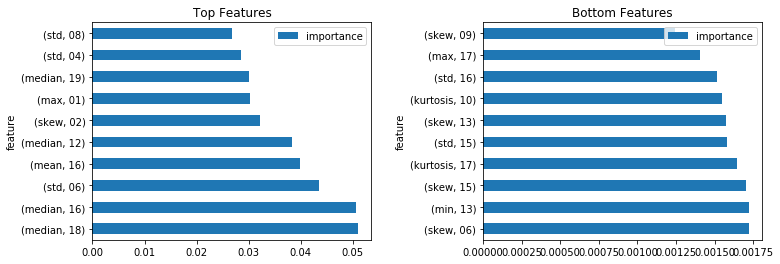

In [208]:
def print_rf_coefs(model, columns, n_head=10):
    importance = model.feature_importances_
    df_importance = pd.DataFrame(data=[list(columns), list(importance)]).transpose()
    df_importance.columns = ['feature', 'importance']
    df_importance = df_importance[df_importance['importance'] != 0]
    # sort by feature importance
    df_importance = df_importance.reindex(df_importance['importance'].abs().sort_values(inplace=False, ascending=False).index)
    display(df_importance.head(n_head))
    display(df_importance.tail(n_head))
    
def plot_rf_coefs(model, columns, n_top=10, n_bottom=10):
    importance = model.feature_importances_
    df_importance = pd.DataFrame(data=[list(columns), list(importance)]).transpose()
    df_importance.columns = ['feature', 'importance']
    df_importance = df_importance[df_importance['importance'] != 0]
    # sort by feature importance
    df_importance = df_importance.reindex(df_importance['importance'].abs().sort_values(inplace=False, ascending=False).index)
    fig, ax = plt.subplots(1, 2, figsize=(12,4), gridspec_kw={'wspace':0.4})
    df_importance.iloc[:n_top].plot(kind='barh', x='feature', y='importance', title='Top Features', ax=ax[0])
    df_importance.iloc[-n_bottom:].plot(kind='barh', x='feature', y='importance', title='Bottom Features', ax=ax[1])
    
plot_rf_coefs(model, df_sc.columns)

Examining the more important features, it is evident that the mean and median MFCC channels which higher-frequencies play a powerful role in the prediction. This is in-line with our expectations.

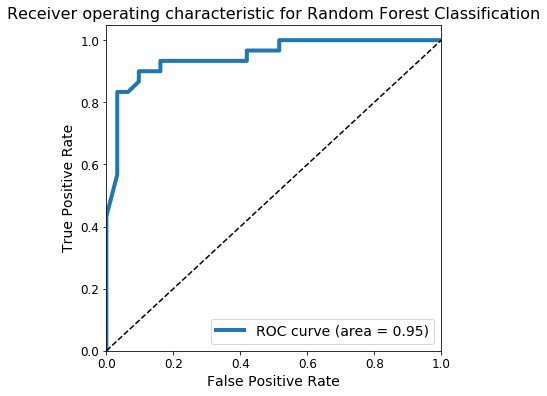

In [24]:
def plot_ROC(model, X, y, title):
    fontsz=12
    predicted = model.predict(X)
    predicted_prob = model.predict_proba(X)[:,1]
    fpr, tpr, _ = roc_curve(np.array(y), predicted_prob)
    area = auc(fpr,tpr)

    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, linewidth=4, label='ROC curve (area = %0.2f)' % area)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=fontsz+2)
    plt.ylabel('True Positive Rate', fontsize=fontsz+2)
    plt.xticks(fontsize=fontsz)
    plt.yticks(fontsize=fontsz)
    plt.title(title, fontsize=fontsz+4)
    plt.legend(loc='lower right', fontsize=fontsz+2)
    plt.show()

plot_ROC(model, X_test, y_test, 'Receiver operating characteristic for Random Forest Classification') 

The ROC curve for this classification signifies a pretty robust classification, with the AOC being 0.95. It also shows that a naive cutoff of 50% on the predicted genre value is good for optimal predictions of this model, with a high rate of TP and a low rate of FP results.

In [25]:
def print_score(model, X, y, name):  
    mse = np.mean(y.values - model.predict(X)) ** 2
    score = model.score(X, y)
    print(f"{name} Mean Square Error: {mse}")
    print(f"{name} Test Score: {score}")

print_score(model, X_test, y_test, 'Random Forest Test')

Random Forest Test Mean Square Error: 5248.751332620387
Random Forest Test Test Score: 0.8688524590163934


In [26]:
y_pred = model.predict(X_test)
report_RF = classification_report(y_test, y_pred)
f1_score_RM = f1_score(y_test, y_pred)

In [27]:
print("Random Forest performance for MFCC separation = 'all'")
print(report_RF)

Random Forest performance for MFCC separation = 'all'
              precision    recall  f1-score   support

           0       0.93      0.81      0.86        31
           1       0.82      0.93      0.87        30

    accuracy                           0.87        61
   macro avg       0.87      0.87      0.87        61
weighted avg       0.88      0.87      0.87        61



### Confusion Matrix

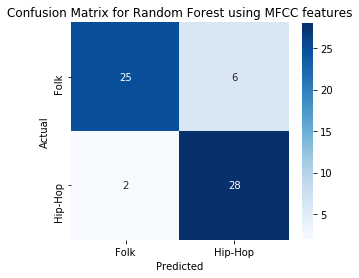

In [28]:
def plot_confusion_matrix(y_test, y_pred, class_names, title=None, cmap=plt.cm.Blues, fontsize=14):
    cm = confusion_matrix(y_test, y_pred) # default confusion matrix, default threshold = 0.5
    df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
    df_cm.index.name = 'Actual'
    df_cm.columns.name = 'Predicted'

    fig, ax = plt.subplots(figsize=(5,5))
    heatmap = sns.heatmap(df_cm, square=True, annot=True, fmt="d", cbar_kws={"shrink": 0.65}, cmap=cmap, ax=ax, )
    ax.set_title(title)
    fig.tight_layout()
    plt.show()

plot_confusion_matrix(y_test, y_pred, ['Folk', 'Hip-Hop'], 
                      title='Confusion Matrix for Random Forest using MFCC features')

The confusion matrix for this small sample demonstrates the perdiction power of the model, with low rates of misclassifications.

Let's examine some of the misclassified tracks:

In [29]:
def play_track(track_id):
    filename = '%s/%06d.wav' % (audio_path, track_id)
    print(filename)
    display(ipd.Audio(filename))

misclass_hiphop = y_test[(y_test['Hip-Hop'] != y_pred) & (y_test['Hip-Hop']==1)]
misclass_folk = y_test[(y_test['Hip-Hop'] != y_pred) & (y_test['Hip-Hop']==0)]

In [30]:
print("Misclassified Folk Track: ", misclass_folk.index[0])
play_track(misclass_folk.index[0])
print("Misclassified Hiphop Track: ", misclass_hiphop.index[1])
play_track(misclass_hiphop.index[1])

Misclassified Folk Track:  12348
data/warmup/012348.wav


Misclassified Hiphop Track:  119979
data/warmup/119979.wav


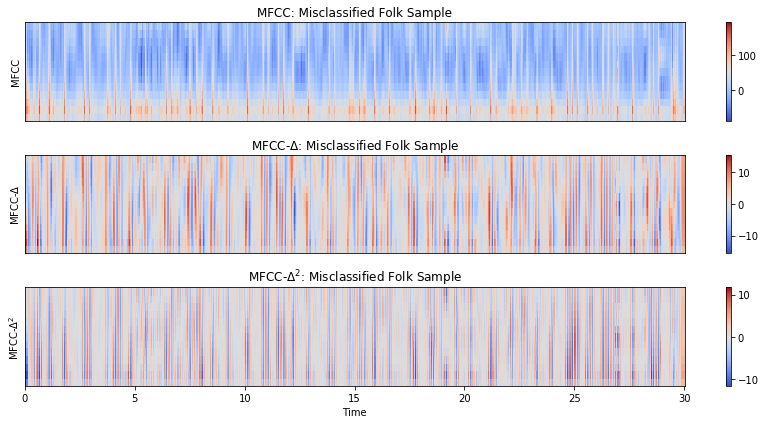

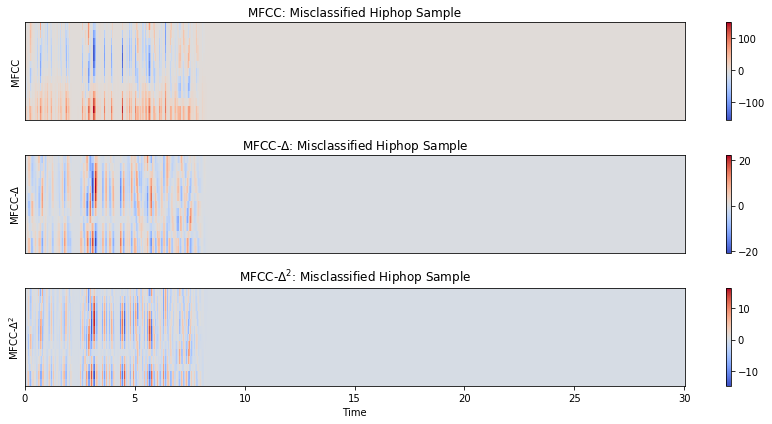

In [31]:
track_ids = [misclass_folk.index[0], misclass_hiphop.index[1]]
filenames = ['%s/%06d.wav' % (audio_path, track_id) for track_id in track_ids]
M_folk = mfcc_plot(filenames[0], 'Misclassified Folk Sample')
M_folk = mfcc_plot(filenames[1], 'Misclassified Hiphop Sample')

The misclassified Hiphop sample is only 8 seconds in length. The silence in the majority of the track skews the MFCC distributions (and especially the mean - the most important feature) to be lower than they normally should be, hence misclassifying the sample. To resolve this, one should cut out any prologned silence from tracks.

The misclassified Folk sample is unusually precussive-heavy for a folk song, with very few instruments that contribute to higher frequencies. This is especially evident in the MFCC-$\Delta$ plots.

# Large Scale Predictions
### Feature Extraction from CSV
After demonstrating the MFCC feature extration with our 200 tracks sample, we will use extracted features from the full 6350 tracks to investigate the full potential of the classification model.

In [209]:
df_features = pd.read_csv("data/fma_metadata/features.csv", index_col=0, header=[0, 1, 2], low_memory=False)
df_tracks = pd.read_csv("data/fma_metadata/tracks.csv", index_col=0, header=[0,1])

In [210]:
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

print("Features:\n=========")
print("Top level columns: ", df_features.columns.levels[0].to_list())
print("Second level columns: ", df_features['mfcc'].columns.levels[0].to_list())

Features:
Top level columns:  ['chroma_cens', 'chroma_cqt', 'chroma_stft', 'mfcc', 'rmse', 'spectral_bandwidth', 'spectral_centroid', 'spectral_contrast', 'spectral_rolloff', 'tonnetz', 'zcr']
Second level columns:  ['kurtosis', 'max', 'mean', 'median', 'min', 'skew', 'std']


In [211]:
df_tracks.head()

album                                                                                                                                                                                    artist                                                                                                                                                                                                                                                                                                                                                                                                                                                    set            track                                                                                                                                                                                                                                                                       
         comments         date_created        date_released engineer favorites id                                information listens producer tags                 title tracks   type    active_year_begin      active_year_end                                  associated_labels                                                bio comments         date_created favorites id   latitude            location  longitude                                            members        name                                   related_projects                                               tags                                  website wikipedia_page     split  subset bit_rate comments   composer         date_created        date_recorded duration favorites genre_top     genres         genres_all information interest language_code                                            license listens lyricist number publisher tags            title
track_id                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
2               0  2008-11-26 01:44:45  2009-01-05 00:00:00      NaN         4  1                                    <p></p>    6073      NaN   []  AWOL - A Way Of Life      7  Album  2006-01-01 00:00:00                  NaN                                                NaN  <p>A Way Of Life, A Collective of Hip-Hop from...        0  2008-11-26 01:42:32         9  1  40.058324          New Jersey -74.405661  Sajje Morocco,Brownbum,ZawidaGod,Custodian of ...        AWOL  The list of past projects is 2 long but every1...                                           ['awol']  http://www.AzillionRecords.blogspot.com            NaN  training   small   256000        0        NaN  2008-11-26 01:48:12  2008-11-26 00:00:00      168         2   Hip-Hop       [21]               [21]         NaN     4656            en  Attribution-NonCommercial-ShareAlike 3.0 Inter...    1293      NaN      3       NaN   []             Food
3               0  2008-11-26 01:44:45  2009-01-05 00:00:00      NaN         4  1                                    <p></p>    6073      NaN   []  AWOL - A Way Of Life      7  Album  2006-01-01 00:00:00                  NaN                                                NaN  <p>A Way Of Life, A Collective of Hip-Hop f

In [212]:
# Extracting mfcc features and true genre classification:
df_mf = pd.DataFrame(df_features['mfcc'])
columns = df_mf.columns
df_mf['genre'] = df_tracks.track.genre_top

In [213]:
# Filter data to only hip-hop and folk:
df_mf = df_mf[df_mf.genre.isin(['Hip-Hop', 'Folk'])]

In [214]:
# Number of tracks by genre:
df_mf['genre'].value_counts()

Hip-Hop    3552
Folk       2803
Name: genre, dtype: int64

## PCA Decomposition

Text(0.5, 1.0, 'Folk/Hiphop MFCC PCA decomposition')

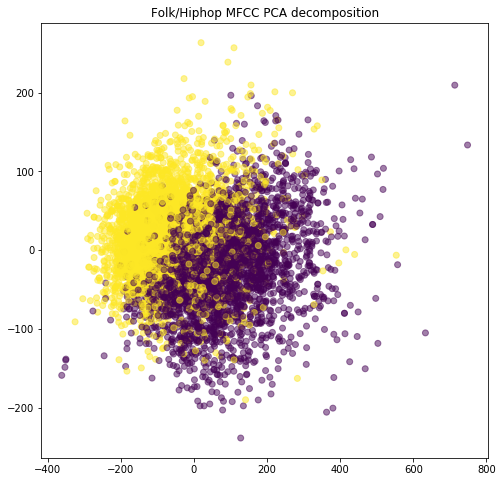

In [215]:
X = df_mf.loc[:, columns]
X = decomposition.PCA(n_components=2).fit_transform(X)
y = df_mf['genre']
y = LabelEncoder().fit_transform(y)

plt.figure(figsize=(8, 8))
plt.scatter(X[:,0], X[:,1], c=y, alpha=0.5)
plt.title('Folk/Hiphop MFCC PCA decomposition')

## Data Preparation
#### Target variable dummification:

In [216]:
df_target = pd.get_dummies(df_mf['genre'], drop_first=True)

#### Data Scaling

In [217]:
std_sca = StandardScaler()
df_sc =  pd.DataFrame(std_sca.fit_transform(df_mf[columns]), columns=columns)

#### Data Splitting
Since we have an abundance of training examples, we will use it to split the data to testing/training/validation set so we can train the model on the **training set**, optimize the model parameter on the **validation set** and then test the performance on the **test set**.

In [218]:
# Split data to train and test set
frac_train = 0.60
frac_test = 0.20
frac_validation = 0.20
seed = 1013
X_train, X_rest, y_train, y_rest = \
    train_test_split(df_sc, df_target, stratify=df_target, train_size=frac_train, random_state=seed)
X_test, X_valid, y_test, y_valid = \
    train_test_split(X_rest, y_rest, stratify=y_rest, train_size=frac_test/(frac_test+frac_validation), random_state=seed)

### Model parameter Optimization

Estimators: 1	Random Forest Train Score:  0.9278783110411749
Estimators: 3	Random Forest Train Score:  0.972987149226331
Estimators: 5	Random Forest Train Score:  0.989247311827957
Estimators: 10	Random Forest Train Score:  0.997639653815893
Estimators: 20	Random Forest Train Score:  0.998688696564385
Estimators: 30	Random Forest Train Score:  1.0
Estimators: 50	Random Forest Train Score:  1.0
Estimators: 70	Random Forest Train Score:  1.0
Estimators: 90	Random Forest Train Score:  1.0
Estimators: 100	Random Forest Train Score:  1.0
Estimators: 500	Random Forest Train Score:  1.0
Estimators: 1000	Random Forest Train Score:  1.0


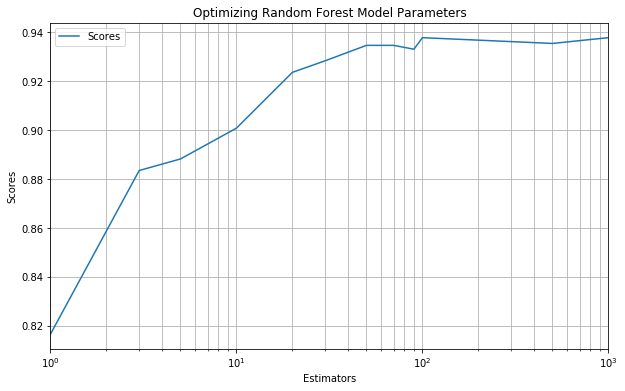

In [219]:
def model_validation(model_func, params, model_name, param_name):
    scores = []
    for param in params:
        print(f'{param_name}: {param}', end='\t')
        model, clf = model_func(X_train, y_train, param)
        score = model.score(X_valid, y_valid)
        scores.append(score)        
    df_scores = pd.DataFrame(index=params, columns={'Scores'}, data=scores)
    df_scores.index.name = param_name
    fig, ax = plt.subplots(figsize=(10,6))
    df_scores.plot(logx=True, title=f'Optimizing {model_name} Model Parameters', ax=ax)
    ax.set_ylabel('Scores')
    ax.grid(which='both')
    return df_scores

estimators = [1, 3, 5, 10, 20, 30, 50, 70, 90, 100, 500, 1000]
df_scores_rf = model_validation(experiment_RF, estimators, 'Random Forest', 'Estimators')

In [220]:
n_estimators=90
model, clf = experiment_RF(X_train, y_train, n_estimators)

Random Forest Train Score:  1.0


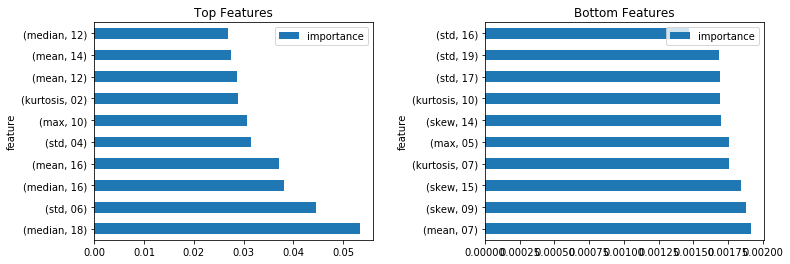

In [221]:
plot_rf_coefs(model, df_sc.columns, 10)

Text(0, 0.5, 'Tracks')

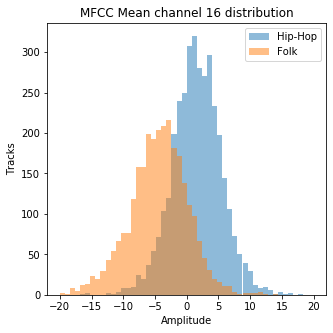

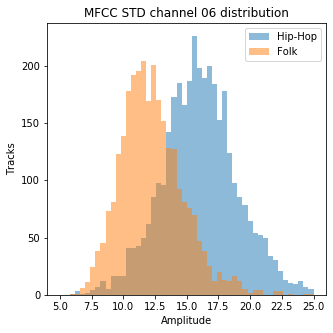

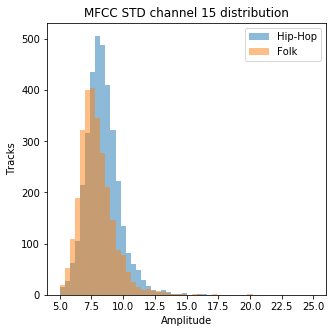

In [222]:
fig, axes = plt.subplots(figsize=(5,5))
plt.hist(df_mf[df_mf.genre == 'Hip-Hop']['mean']['16'], 50, alpha=0.5, label='Hip-Hop', range=(-20, 20))
plt.hist(df_mf[df_mf.genre == 'Folk']['mean']['16'], 50, label='Folk', alpha=0.5, range=(-20, 20))
plt.legend(loc='upper right')
plt.title('MFCC Mean channel 16 distribution')
plt.xlabel('Amplitude')
plt.ylabel('Tracks')

fig, ax = plt.subplots(figsize=(5,5))
plt.hist(df_mf[df_mf.genre == 'Hip-Hop']['std']['06'], 50, alpha=0.5, label='Hip-Hop', range=(5, 25))
plt.hist(df_mf[df_mf.genre == 'Folk']['std']['06'], 50, label='Folk', alpha=0.5, range=(5, 25))
plt.legend(loc='upper right')
plt.title('MFCC STD channel 06 distribution')
plt.xlabel('Amplitude')
plt.ylabel('Tracks')

fig, ax = plt.subplots(figsize=(5,5))
plt.hist(df_mf[df_mf.genre == 'Hip-Hop']['std']['15'], 50, alpha=0.5, label='Hip-Hop', range=(5, 25))
plt.hist(df_mf[df_mf.genre == 'Folk']['std']['15'], 50, label='Folk', alpha=0.5, range=(5, 25))
plt.legend(loc='upper right')
plt.title('MFCC STD channel 15 distribution')
plt.xlabel('Amplitude')
plt.ylabel('Tracks')

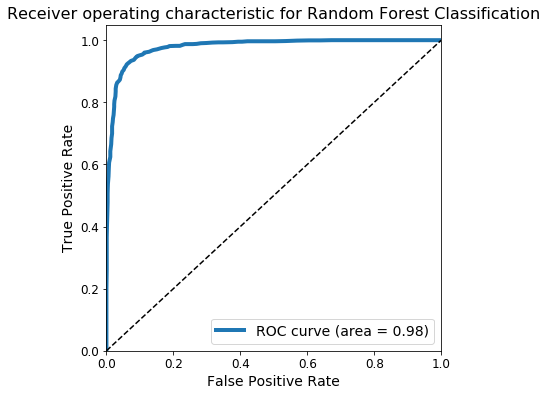

In [223]:
plot_ROC(model, X_rest, y_rest, 'Receiver operating characteristic for Random Forest Classification') 

In [224]:
y_pred = model.predict(X_rest)
report_RF = classification_report(y_rest, y_pred)
f1_score_RF = f1_score(y_rest, y_pred)
print("Random Forest MFCC separation performance for full dataset")
print(report_RF)

Random Forest MFCC separation performance for full dataset
              precision    recall  f1-score   support

           0       0.92      0.92      0.92      1121
           1       0.94      0.94      0.94      1421

    accuracy                           0.93      2542
   macro avg       0.93      0.93      0.93      2542
weighted avg       0.93      0.93      0.93      2542



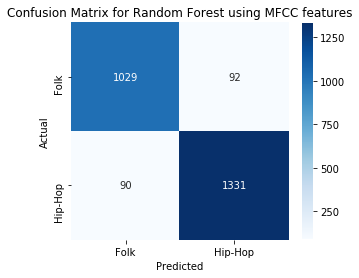

In [225]:
plot_confusion_matrix(y_rest, y_pred, ['Folk', 'Hip-Hop'], 
                      title='Confusion Matrix for Random Forest using MFCC features')

## KNeighborsClassifier

In [48]:
def experiment_KN(X_train, y_train, n_neighbors):
    model = KNeighborsClassifier(n_neighbors=n_neighbors)
    clf = model.fit(X_train, np.ravel(y_train))
    mse = np.mean(y_train.values - model.predict(X_train)) ** 2
    score = model.score(X_train, y_train)
    print('KNeighbors Train Score: ', score)
    return model, clf

Neighbors: 1	KNeighbors Train Score:  1.0
Neighbors: 3	KNeighbors Train Score:  0.949908208759507
Neighbors: 10	KNeighbors Train Score:  0.932336742722266
Neighbors: 30	KNeighbors Train Score:  0.912667191188041
Neighbors: 100	KNeighbors Train Score:  0.8948334644636768
Neighbors: 300	KNeighbors Train Score:  0.8767374770521899
Neighbors: 1000	KNeighbors Train Score:  0.8518227117755048


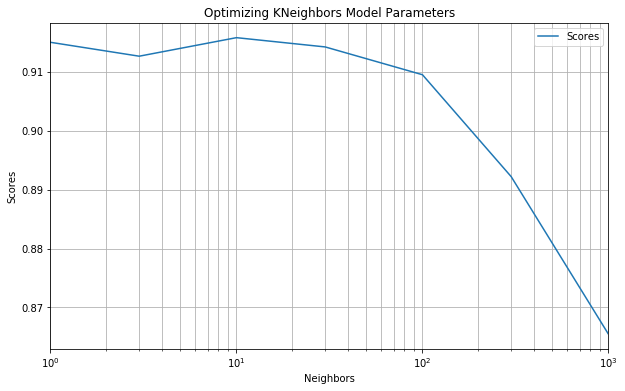

In [58]:
neighbors = [1, 3, 10, 30, 100, 300, 1000]
df_scores_kn = model_validation(experiment_KN, neighbors, 'KNeighbors', 'Neighbors')

In [50]:
n_neighbors = 10
model, clf = experiment_KN(X_train, y_train, n_neighbors)

KNeighbors Train Score:  0.932336742722266


In [51]:
y_pred = model.predict(X_rest)
report_KN = classification_report(y_rest, y_pred)
f1_score_KN = f1_score(y_rest, y_pred)
print("KNeighbors MFCC separation performance for full dataset")
print(report_KN)

KNeighbors MFCC separation performance for full dataset
              precision    recall  f1-score   support

           0       0.91      0.91      0.91      1121
           1       0.93      0.93      0.93      1421

    accuracy                           0.92      2542
   macro avg       0.92      0.92      0.92      2542
weighted avg       0.92      0.92      0.92      2542



## Logistic Regression

In [52]:
def experiment_LR(X_train, y_train, C):
    model = LogisticRegression(penalty='l2', C=C, max_iter=10000, solver='lbfgs')
    clf = model.fit(X_train, np.ravel(y_train))
    mse = np.mean(y_train.values - model.predict(X_train)) ** 2
    score = model.score(X_train, y_train)
    print('Logistic Regression Train Score: ', score)
    return model, clf

Penalty ($1/\lambda$): 0.0001	Logistic Regression Train Score:  0.8819826907946499
Penalty ($1/\lambda$): 0.001	Logistic Regression Train Score:  0.9147652766850249
Penalty ($1/\lambda$): 0.01	Logistic Regression Train Score:  0.932074482035143
Penalty ($1/\lambda$): 0.03	Logistic Regression Train Score:  0.9352216102806189
Penalty ($1/\lambda$): 0.1	Logistic Regression Train Score:  0.937581956464726
Penalty ($1/\lambda$): 0.3	Logistic Regression Train Score:  0.9399423026488329
Penalty ($1/\lambda$): 1	Logistic Regression Train Score:  0.9417781274586939
Penalty ($1/\lambda$): 3	Logistic Regression Train Score:  0.9425649095200629
Penalty ($1/\lambda$): 10	Logistic Regression Train Score:  0.943089430894309
Penalty ($1/\lambda$): 30	Logistic Regression Train Score:  0.9417781274586939
Penalty ($1/\lambda$): 100	Logistic Regression Train Score:  0.9423026488329399


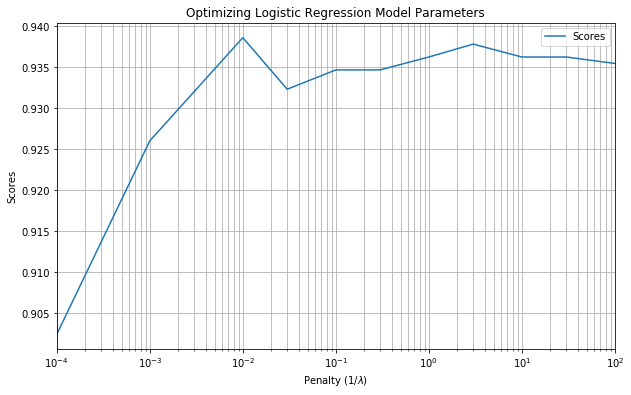

In [59]:
penalties = [0.0001, 0.001, 0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100]
df_scores_rbf = model_validation(experiment_LR, penalties, 'Logistic Regression', 'Penalty ($1/\lambda$)')

In [54]:
penalty = 0.01
model, clf = experiment_LR(X_train, y_train, penalty)
y_pred = model.predict(X_rest)
report_KN = classification_report(y_rest, y_pred)
f1_score_KN = f1_score(y_rest, y_pred)
print("KNeighbors MFCC separation performance for full dataset")
print(report_KN)

Logistic Regression Train Score:  0.932074482035143
KNeighbors MFCC separation performance for full dataset
              precision    recall  f1-score   support

           0       0.94      0.92      0.93      1121
           1       0.94      0.95      0.95      1421

    accuracy                           0.94      2542
   macro avg       0.94      0.94      0.94      2542
weighted avg       0.94      0.94      0.94      2542



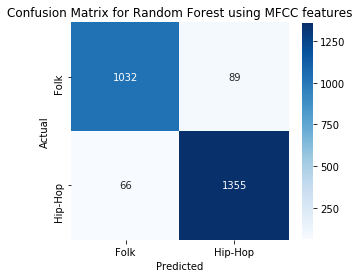

In [55]:
plot_confusion_matrix(y_rest, y_pred, ['Folk', 'Hip-Hop'], 
                      title='Confusion Matrix for Random Forest using MFCC features')